Figuring out how to output roundness/sharpness, and looking into
what happens when using two different aperture sizes.

In [1]:
import numpy as np
from matplotlib import pyplot as plt

from astropy.io import fits
from astropy.stats import sigma_clipped_stats
from photutils import aperture_photometry,CircularAnnulus,CircularAperture
from photutils import DAOStarFinder

In [2]:
from drizzlepac import pixtopix

The following task in the stsci.skypac package can be run with TEAL:
                                    skymatch                                    
The following tasks in the drizzlepac package can be run with TEAL:
    astrodrizzle       imagefindpars           mapreg              photeq       
     pixreplace           pixtopix            pixtosky        refimagefindpars  
     resetbits          runastrodriz          skytopix           tweakback      
      tweakreg           updatenpol


In [2]:
# image = 'hor1DRCs/jdan20010_drc.fits'
# hdu = fits.open(image)
# sci = hdu[1].data
# hdr = hdu[0].header
# tab = hdu[4].data
# photflam = hdu[1].header['PHOTFLAM']

# data = hdu[1].data
# hdu.close()

# temp_sci=data*hdr['texptime']

# fits.writeto('hor1DRCs/F814W_ctsALL_raw.fits', temp_sci, header=hdr)

In [3]:
image = 'hor1DRCs/F814W_ctsALL_raw.fits'
# fits.info(image)

hdu = fits.open(image)
sci = hdu[0].data
hdr = hdu[0].header
hdu.close()

In [4]:
data = sci.copy()

In [5]:
mean, median, std = sigma_clipped_stats(data, sigma=3.0, maxiters=5)
print(mean, median, std)

0.49618652 -0.06826966 19.541706


In [6]:
daofind = DAOStarFinder(fwhm=2., threshold=5.*std)
sources = daofind(data - median)
print(len(sources))

6557


In [203]:
# daofind1 = DAOStarFinder(fwhm=2.5, threshold=5.*std)
# sources1 = daofind1(data - median)
# print(len(sources1))

430803


In [7]:
positions = np.transpose((sources['xcentroid'], sources['ycentroid']))
apertures_r4 = CircularAperture(positions, r=4.)

rawflux_r4 = aperture_photometry(data, apertures_r4)

In [8]:
rawflux_r4['roundness1']= sources['roundness1']
rawflux_r4['roundness2']= sources['roundness2']
rawflux_r4['sharpness']= sources['sharpness']

In [9]:
annulus_apertures = CircularAnnulus(positions, r_in=9., r_out=12.)

annulus_masks = annulus_apertures.to_mask(method='center')

bkg_median = []
for mask in annulus_masks:
    
    annulus_data = mask.multiply(data)
    annulus_data_1d = annulus_data[mask.data > 0]
    _, median_sigclip, _ = sigma_clipped_stats(annulus_data_1d)
    bkg_median.append(median_sigclip)

bkg_median = np.array(bkg_median)

In [10]:
rawflux_r4['annulus_median'] = bkg_median
rawflux_r4['aper_bkg'] = bkg_median*apertures_r4.area
rawflux_r4['final_phot'] = rawflux_r4['aperture_sum'] - rawflux_r4['aper_bkg']

In [11]:
apertures_r6 = CircularAperture(positions, r=6.)
rawflux_r6 = aperture_photometry(data, apertures_r6)

rawflux_r6['aper_bkg'] = rawflux_r4['annulus_median']*apertures_r6.area
rawflux_r6['final_phot'] = rawflux_r6['aperture_sum'] - rawflux_r6['aper_bkg']

In [12]:
mask_negative = (rawflux_r4['final_phot'] > 0) & (rawflux_r6['final_phot'] > 0)

rawflux_pos_r4 = rawflux_r4[mask_negative]
rawflux_pos_r6 = rawflux_r6[mask_negative]

mag_r4 = -2.5*np.log10(rawflux_pos_r4['final_phot'])
mag_r6 = -2.5*np.log10(rawflux_pos_r6['final_phot'])

deltamag = mag_r4 - mag_r6

In [57]:
type(rawflux_pos_r4)

astropy.table.table.QTable

In [49]:
len(du[0])

5986

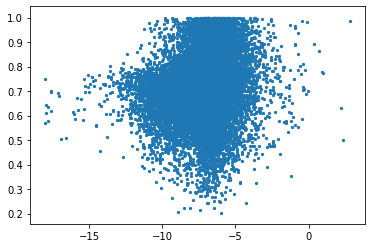

In [35]:
fig,ax = plt.subplots()

ax.scatter(mag_r4,rawflux_pos_r4['sharpness'],s=5)

plt.show()

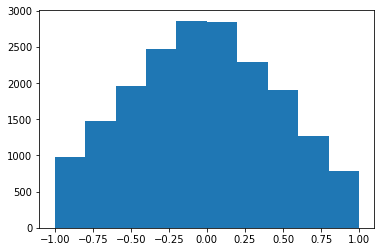

In [36]:
plt.hist(rawflux_pos_r4['roundness1'])
plt.show()

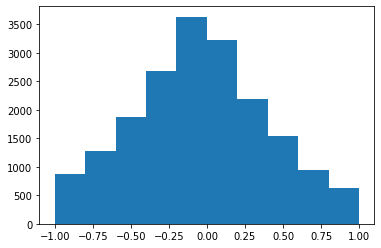

In [37]:
plt.hist(rawflux_pos_r4['roundness2'])
plt.show()

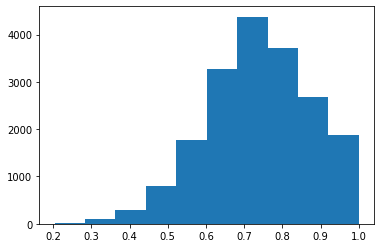

In [38]:
plt.hist(rawflux_pos_r4['sharpness'])
plt.show()

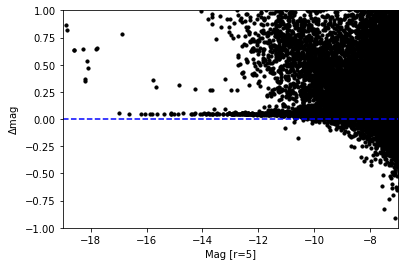

In [39]:
plt.figure()
plt.scatter(mag_r6, deltamag, c='k', s=10)
plt.axhline(ls='--', c='b')
plt.xlim(-19,-7)
plt.ylim(-1,1)
plt.xlabel('Mag [r=5]')
plt.ylabel('$\Delta$mag')

plt.show()

0.049956437237242746


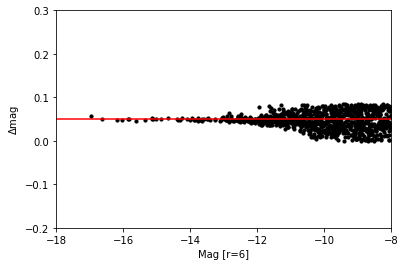

In [13]:
mask = (mag_r6 > -17.) & (mag_r6 < -8.) & (deltamag > 0) & (deltamag < 0.1)

mean, median, std = sigma_clipped_stats(deltamag[mask], sigma=3.0, maxiters=5)
apcor = median
print(apcor)

# mean, median, std = sigma_clipped_stats(deltamag, sigma=1.0, cenfunc='median')
# apcor = median
# print(apcor)

new_mask = (mag_r6 > -17.) & (mag_r6 < -8.) & (deltamag > 0) & (deltamag < apcor + 1.5*std)

fig,ax = plt.subplots()
ax.scatter(mag_r6[new_mask], deltamag[new_mask], c='k', s=10)
ax.axhline(apcor,ls='-',c='r')
ax.set_xlim(-18,-8)
ax.set_ylim(-0.2,0.3)
ax.set_xlabel('Mag [r={0}]'.format(4+2))
ax.set_ylabel(r'$\Delta$mag')
# plt.axhline(apcor,ls='-',c='r')
# plt.xlim(-18,-8)
# plt.ylim(-0.2,0.2)
# plt.xlabel('Mag [r=5]')
# plt.ylabel('$\Delta$mag')
plt.show()

In [30]:
test = np.zeros((len(rawflux_pos_r4),1))
test[:,0]=(rawflux_pos_r4['xcenter'])

In [33]:
type(test)

numpy.ndarray

In [36]:
test.flatten()[:10]

array([ 104.08768561,  129.94330774,  122.19923617,   16.62030199,
        251.18584225,  278.47839424,  556.86019464,  784.58997256,
        586.78636308, 1426.55045705])

In [37]:
xt1,yt1 = pixtopix.tran('hor1DRCs/jdan20010_drc.fits[sci,1]',
                                    'hor1DRCs/jdan21010_drc.fits[sci,1]','forward',
                                    x=test.flatten(),
                                    y=test.flatten())

# Coordinate transformations for  hor1DRCs/jdan20010_drc.fits[sci,1]
# X(in)      Y(in)             X(out)         Y(out)

104.0877  104.0877    104.315593  104.159285
129.9433  129.9433    130.171221  130.014902
122.1992  122.1992    122.427147  122.270832
16.6203  16.6203    16.848191  16.691920
251.1858  251.1858    251.413781  251.257410
278.4784  278.4784    278.706339  278.549956
556.8602  556.8602    557.088199  556.931697
784.5900  784.5900    784.818025  784.661427
586.7864  586.7864    587.014373  586.857859
1426.5505  1426.5505    1426.778647  1426.621774
1482.2693  1482.2693    1482.497460  1482.340563
596.0591  596.0591    596.287090  596.130572
1040.4008  1040.4008    1040.628907  1040.472199
145.9201  145.9201    146.148043  145.991717
2075.0173  2075.0173    2075.245617  2075.088468
1872.0031  1872.0031    1872.231386  1872.074323
1180.0577  1180.0577    1180.285831  1180.129063
929.2470  929.2470    929.475120  929.318460
2564.1757  2564.1757    2564.404093  2564.24673

2664.0239  2664.0239    2664.252375  2664.094974
2807.7777  2807.7777    2808.006147  2807.848684
4072.7434  4072.7434    4072.972183  4072.814179
984.9267  984.9267    985.154749  984.998065
1439.9154  1439.9154    1440.143629  1439.986751
1467.4460  1467.4460    1467.674239  1467.517349
2292.4493  2292.4493    2292.677636  2292.520393
1199.7099  1199.7099    1199.938074  1199.781298
2963.8010  2963.8010    2964.029478  2963.871948
3788.6142  3788.6142    3788.842870  3788.684989
564.8246  564.8246    565.052591  564.896086
1534.5579  1534.5579    1534.786144  1534.629225
3336.9928  3336.9928    3337.221418  3337.063729
1913.9853  1913.9853    1914.213582  1914.056501
2358.9186  2358.9186    2359.146986  2358.989714
2691.7068  2691.7068    2691.935284  2691.777871
1040.1759  1040.1759    1040.404026  1040.247318
258.9649  258.9649    259.192884  259.036510
538.6765  538.6765    538.904464  538.747971
778.3287  778.3287    778.556729  778.400133
1462.0352  1462.0352    1462.263416  146

3905.2552  3905.2552    3905.483922  3905.325991
1916.0047  1916.0047    1916.232972  1916.075890
3160.5045  3160.5045    3160.733058  3160.575444
3958.8087  3958.8087    3959.037460  3958.879505
1210.3018  1210.3018    1210.529971  1210.373191
3516.7150  3516.7150    3516.943660  3516.785895
201.0739  201.0739    201.301809  201.145459
2421.8401  2421.8401    2422.068540  2421.911242
2910.8826  2910.8826    2911.111087  2910.953580
4004.3414  4004.3414    4004.570181  4004.412207
649.2989  649.2989    649.526957  649.370416
1907.3776  1907.3776    1907.605898  1907.448820
917.2195  917.2195    917.447546  917.290891
4158.8870  4158.8870    4159.115778  4158.957738
450.7922  450.7922    451.020177  450.863721
543.8238  543.8238    544.051841  543.895345
1899.2560  1899.2560    1899.484254  1899.327180
2014.0792  2014.0792    2014.307474  2014.150350
3788.5516  3788.5516    3788.780272  3788.622391
1001.2098  1001.2098    1001.437914  1001.281223
2587.8253  2587.8253    2588.053769  258

In [126]:
test1 = mag_r6[new_mask]

In [54]:
t = [1,2,3,4,5]
a = [5,6,7,6,8]

In [55]:
ta = np.vstack((t,a))

In [56]:
print(ta)

[[1 2 3 4 5]
 [5 6 7 6 8]]


In [127]:
len(test1)

938

In [66]:
len(mask)

5986

In [129]:
mask[:10]

array([False,  True, False, False, False, False,  True, False, False,
       False])

In [130]:
newCol = np.zeros((len(mask),1))
for ii in range(len(mask)):
    if mask[ii]==True:
        newCol[ii]=int(1)
    else:
        newCol[ii]=int(0)

In [131]:
rawflux_pos_r4['six_4_flag'] = newCol

In [134]:
EEband = 0.77
ZPT = 26.779

In [135]:
final_phot = -2.5 * np.log10(rawflux_pos_r4['final_phot'] / EEband) \
            + 2.5 * np.log10(hdr['exptime']) + ZPT

In [136]:
rawflux_pos_r4['magr_f814w'] = final_phot

In [137]:
s0 = ' '
header = s0.join(rawflux_pos_r4.dtype.names)

In [138]:
np.savetxt('./drcPhot02Nov/HOROLOGIUM-I_newFlag.dat',rawflux_pos_r4,header=header)

In [99]:
print(len(test1)/5986) # approximately 5 percent of sources are kept

0.220180420982292


In [72]:
sg = np.genfromtxt('./catRawMags20Aug/catDir_HOROLOGIUM-I/classStarCat_F606Wmatch_HOROLOGIUM-I.dat',
                  names=True)

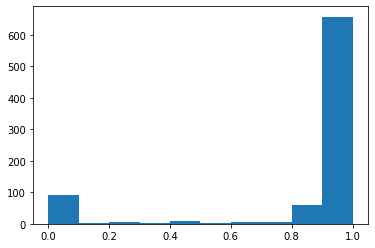

In [73]:
plt.hist(sg['c_star_f606w'])
plt.show()

In [81]:
sg_mask = sg['c_star_f606w'] > 0.8

In [82]:
test = sg[sg_mask]
print(len(test)/len(sg))

0.8497041420118343


In [83]:
len(test)

718

In [58]:
test = ['jdan12000','why','okay']

In [60]:
test[0][:6]

'jdan12'

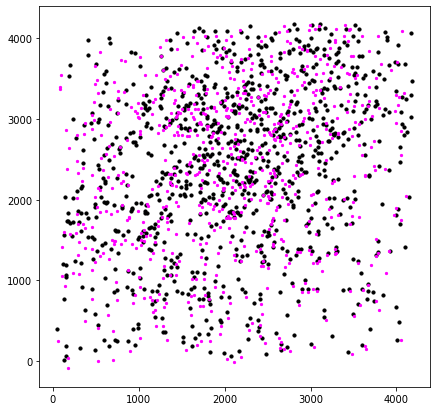

In [128]:
fig, ax = plt.subplots(figsize=(7,7))


ax.scatter(rawflux_pos_r4['xcenter'][new_mask],
           rawflux_pos_r4['ycenter'][new_mask],s=10,color='black')
ax.scatter(sg['xt1_f606w'][sg_mask],sg['yt1_f606w'][sg_mask],s=5,color='magenta')


plt.show()

In [51]:
len(sg)

845

In [144]:
newM = np.genfromtxt('./drcPhot02Nov/sePU10Nov/HOROLOGIUM-I_fullSEpu.dat',names=True)

In [196]:
len(newM)

1419

In [145]:
mask = newM['six_4_flag']==1

In [172]:
mask2 = newM['class_Star_i']>=0.95

In [163]:
mask3 = (newM['six_4_flag']==1) & (newM['class_Star_i']>=0.9)
good3=newM[mask3]
print(len(good3))

725


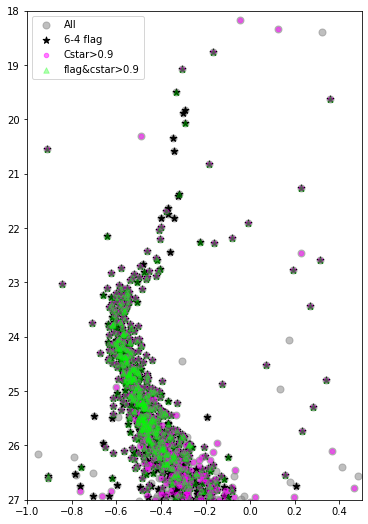

In [198]:
fig,ax = plt.subplots(figsize=(6,9))

ax.scatter(newM['magRaw_v']-newM['magRaw_i'],newM['magRaw_v'],s=50,
           color='grey',label='All',alpha=0.5)
ax.scatter(good['magRaw_v']-good['magRaw_i'],good['magRaw_v'],s=50,marker='*',
           color='black',label='6-4 flag')
ax.scatter(good2['magRaw_v']-good2['magRaw_i'],good2['magRaw_v'],s=20,
           alpha=0.5,label='Cstar>0.9',color='magenta')
ax.scatter(good3['magRaw_v']-good3['magRaw_i'],good3['magRaw_v'],s=30,
           alpha=0.3,label='flag&cstar>0.9',color='lime',marker='^')


#1419,850, 831, 725 -- 938 intially passed the flag test
ax.set_ylim(27,18)
ax.set_xlim(-1,0.5)
ax.legend()

plt.show()

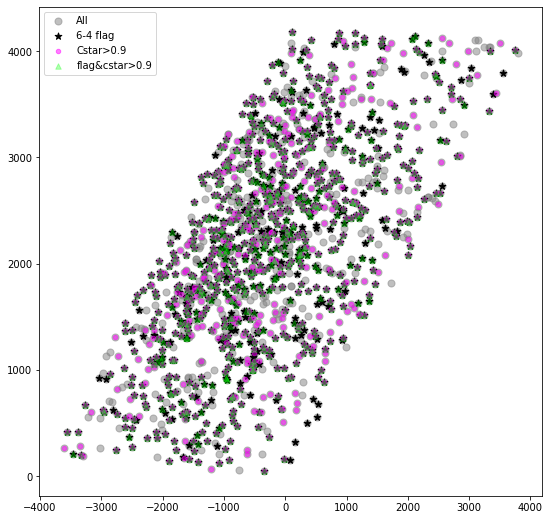

In [200]:
fig,ax = plt.subplots(figsize=(9,9))

ax.scatter(newM['x_v']-newM['y_v'],newM['x_v'],s=50,
           color='grey',label='All',alpha=0.5)
ax.scatter(good['x_v']-good['y_v'],good['x_v'],s=50,marker='*',
           color='black',label='6-4 flag')
ax.scatter(good2['x_v']-good2['y_v'],good2['x_v'],s=20,
           alpha=0.5,label='Cstar>0.9',color='magenta')
ax.scatter(good3['x_v']-good3['y_v'],good3['x_v'],s=30,
           alpha=0.3,label='flag&cstar>0.9',color='lime',marker='^')


#1419,850, 831, 725 -- 938 intially passed the flag test
# ax.set_ylim(27,18)
# ax.set_xlim(-1,0.5)
ax.legend()

plt.show()

In [173]:
good2 = newM[mask2]
print(len(good2))

831


In [146]:
good = newM[mask]

In [148]:
len(good)

850

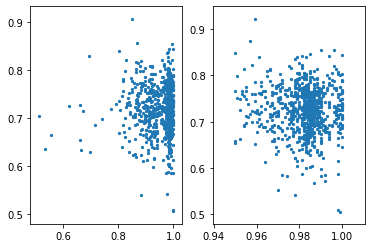

In [156]:
fig,(ax1,ax2) = plt.subplots(1,2)


ax1.scatter(good['class_Star_i'],good['sharpness'],s=5)
ax2.scatter(good2['class_Star_i'],good2['sharpness'],s=5)

plt.show()


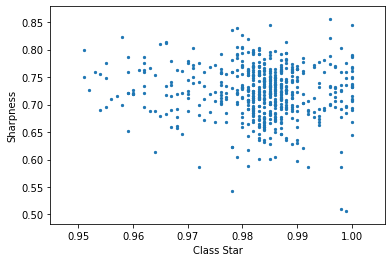

In [161]:
fig,ax = plt.subplots()


# ax1.scatter(good['class_Star_i'],good['sharpness'],s=5)
ax.scatter(good3['class_Star_i'],good3['sharpness'],s=5)
ax.set_xlabel('Class Star')
ax.set_ylabel('Sharpness')

plt.show()


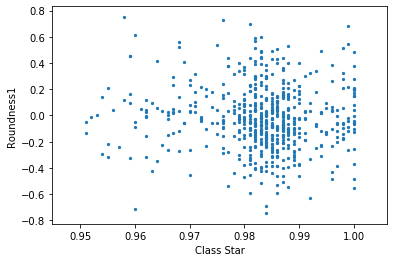

In [162]:
fig,ax = plt.subplots()


# ax1.scatter(good['class_Star_i'],good['sharpness'],s=5)
ax.scatter(good3['class_Star_i'],good3['roundness1'],s=5)
ax.set_xlabel('Class Star')
ax.set_ylabel('Roundness1')

plt.show()


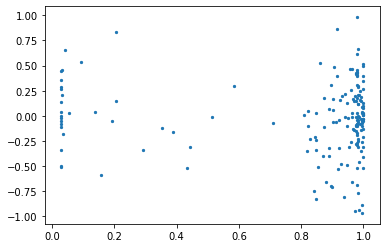

In [143]:
fig,ax = plt.subplots()


ax.scatter(newM['c_star_f814w'],newM['roundness1'],s=5)

plt.show()

In [16]:
image = 'hor1DRCs/jdan20010_drc.fits'

# fits.info(image)

hdu = fits.open(image)
hdr = hdu[0].header
photflam = hdu[1].header['PHOTFLAM']

hdu.close()

In [22]:
other = -2.5*np.log10(photflam/hdr['texptime']/0.839)
print(other)

56.73998765094548


In [18]:
ap_cor = -2.5 * np.log10(0.839)
print(ap_cor)

0.19059509792824936


In [205]:
zpt = 26.779

In [20]:
final_phot = -2.5*np.log10(rawflux_pos_r4['final_phot']) - apcor + zpt
print(final_phot[:20])

    final_phot    
------------------
 20.35397257440397
 18.58672007905273
 19.79914061920007
16.506791463510748
18.492237715742093
 16.70951992861134
 18.44681254040968
17.913452190357013
17.538297481614954
18.916625729695877
17.632906105590184
 19.29276336485581
17.260061384691596
 16.32444186019248
16.831581429919378
 20.08607464327332
19.013617836537787
18.664997338917207
 18.85544068551983
19.242314260365582


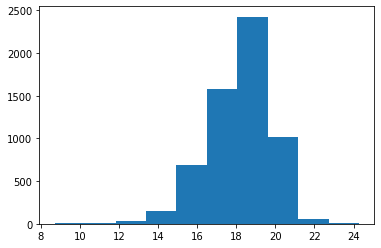

In [21]:
plt.hist(final_phot)
plt.show()

In [2]:
image = './PISCES-II_f814w/crClean/jdan87n2q_crclean.fits'
fits.info(image)

hdu = fits.open(image)
# sci = hdu[0].data
# hdr = hdu[0].header
# hdu.close()



Filename: ./PISCES-II_f814w/crClean/jdan87n2q_crclean.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     285   ()      
  1  SCI           1 ImageHDU       200   (4096, 2048)   float32   
  2  ERR           1 ImageHDU        56   (4096, 2048)   float32   
  3  DQ            1 ImageHDU        50   (4096, 2048)   int16 (rescales to uint16)   
  4  SCI           2 ImageHDU       198   (4096, 2048)   float32   
  5  ERR           2 ImageHDU        56   (4096, 2048)   float32   
  6  DQ            2 ImageHDU        48   (4096, 2048)   int16   
  7  D2IMARR       1 ImageHDU        15   (64, 32)   float32   
  8  D2IMARR       2 ImageHDU        15   (64, 32)   float32   
  9  D2IMARR       3 ImageHDU        15   (64, 32)   float32   
 10  D2IMARR       4 ImageHDU        15   (64, 32)   float32   
 11  WCSDVARR      1 ImageHDU        15   (64, 32)   float32   
 12  WCSDVARR      2 ImageHDU        15   (64, 32)   float32   
 13  WCSDVARR      

In [11]:
image = './PISCES-II_f814w/crClean/jdan87n2q_crclean.fits'
# fits.info(image)

hdu = fits.open(image)
sci2 = hdu[1].data
sci1 = hdu[4].data
hdr = hdu[0].header
# hdu.close()
print(sci1[:10])
print(sci2[:10])

[[ 14.647638  70.12602   85.7785   ...  83.46055   69.331375  79.98504 ]
 [ 18.066437  72.50334  124.70146  ...  81.34968   92.62531   95.03127 ]
 [ 34.94454  107.217384  74.3973   ... 109.51467   99.982635  69.38777 ]
 ...
 [ 59.458984  89.90967  120.634445 ...  93.036194  97.7773    92.603935]
 [ 59.364502  99.5321    92.24674  ... 110.84899  178.90045   83.468216]
 [ 50.385387  53.37443   69.60044  ... 115.87617   97.05812  127.73875 ]]
[[4.17979248e-02 3.64204597e+00 5.28607368e+00 ... 3.54235992e+01
  2.42887383e+01 4.35858917e+01]
 [9.59134064e+01 9.94570618e+01 7.11236649e+01 ... 1.03223343e+02
  7.08834686e+01 1.12307068e+02]
 [1.01435768e+02 1.02323227e+02 8.54747391e+01 ... 9.04884186e+01
  9.73578796e+01 8.60230713e+01]
 ...
 [9.36753922e+01 9.64060593e+01 9.98075562e+01 ... 9.59359894e+01
  1.04825348e+02 9.20416870e+01]
 [1.02159714e+02 8.74439621e+01 8.08476028e+01 ... 9.09287949e+01
  7.17352982e+01 8.98543167e+01]
 [1.14823486e+02 8.72370911e+01 9.36274033e+01 ... 1.004

In [6]:
hdu.close()
data1 = sci.copy()

In [9]:
mean, median, std = sigma_clipped_stats(data1, sigma=3.0, maxiters=5)
print(mean, median, std)

94.071846 93.81377 13.066324


In [10]:
daofind = DAOStarFinder(fwhm=2., threshold=5.*std)
sources = daofind(data1 - median)
print(len(sources))

3049


In [13]:
image = './PISCES-II_f814w/crClean/jdan87n2q_WJ2.fits'
hdu = fits.open(image)
fits.info(image)

Filename: ./PISCES-II_f814w/crClean/jdan87n2q_WJ2.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  SCI           1 PrimaryHDU     522   (4096, 4096)   int16 (rescales to float32)   
